# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

***NOTE: The Dateframe is on a daily thus the several crossings on the charts.

### 1. Importing your libraries and data

Before you start this analysis, you'll need a new library you haven't installed before—Quandl. Install Quandl using conda:

`conda install quandl`

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'PFTQwes7GPSoceVvocX3'

In [3]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

#data = quandl.get_table('FRED/RSXFS')
data = quandl.get_table('ZILLOW/DATA')
#data = quandl.get_table('ZACKS/FC', ticker='AAPL')

In [4]:
data.head(5)

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2024-07-31,486230.166077
1,ZSFH,99999,2024-06-30,485893.210056
2,ZSFH,99999,2024-05-31,484599.091201
3,ZSFH,99999,2024-04-30,481777.608669
4,ZSFH,99999,2024-03-31,480423.651093


In [5]:
data.set_index('date', inplace=True)

In [6]:
data.head(5)

,indicator_id,region_id,value
date,,,
2024-07-31,ZSFH,99999,486230.166077
2024-06-30,ZSFH,99999,485893.210056
2024-05-31,ZSFH,99999,484599.091201
2024-04-30,ZSFH,99999,481777.608669
2024-03-31,ZSFH,99999,480423.651093


In [7]:
# Create a subset containing only 2 important numerical variables
data_numerical = data.drop(columns=['indicator_id', 'region_id'])

In [8]:
data_numerical.shape

(10000, 1)

In [9]:
data_numerical.columns

Index(['value'], dtype='object')

In [10]:
type(data)

pandas.core.frame.DataFrame

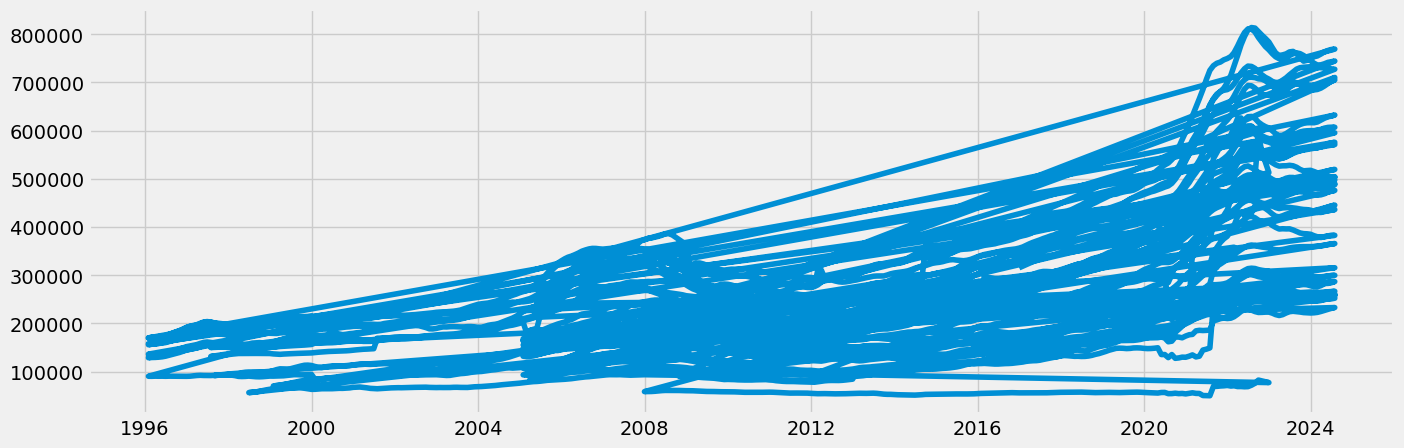

In [11]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data_numerical)

*** Note: The dataframe seems to be on a daily and therefore a lot going on with it hence the several crossings.

### 2. Subsetting, wrangling, and cleaning time-series data

In [12]:
# Reset index so that you can use the "Date" column as a filter

data_numerical_2 = data.reset_index()

In [13]:
data_numerical_2.head()

,date,indicator_id,region_id,value
0,2024-07-31,ZSFH,99999,486230.166077
1,2024-06-30,ZSFH,99999,485893.210056
2,2024-05-31,ZSFH,99999,484599.091201
3,2024-04-30,ZSFH,99999,481777.608669
4,2024-03-31,ZSFH,99999,480423.651093


In [14]:
# Create a subset containing only 2 important numerical variables
data_numerical_2 = data_numerical_2.drop(columns=['indicator_id', 'region_id'])

In [15]:
data_numerical_2.head()

,date,value
0,2024-07-31,486230.166077
1,2024-06-30,485893.210056
2,2024-05-31,484599.091201
3,2024-04-30,481777.608669
4,2024-03-31,480423.651093


In [16]:
data_numerical_2_sub = data_numerical_2.loc[(data_numerical_2['date'] >= '2024-01-31') & (data_numerical_2['date'] < '2024-06-30')]

*** NOTE: The dataframe seems too large even for a 6 month period.

In [18]:
data_numerical_2_sub.shape

(160, 2)

In [19]:
data_numerical_2_sub.head()

,date,value
2,2024-05-31,484599.091201
3,2024-04-30,481777.608669
4,2024-03-31,480423.651093
5,2024-02-29,480905.942125
6,2024-01-31,484672.057701


In [20]:
# Set the "Date" column as the index

from datetime import datetime

data_numerical_2_sub['datetime'] = pd.to_datetime(data_numerical_2_sub['date']) # Create a datetime column from "Date.""
data_numerical_2_sub = data_numerical_2_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_numerical_2_sub.drop(['date'], axis=1, inplace=True) # Drop the "date" column.
data_numerical_2_sub.head()

,value
datetime,
2024-05-31,484599.091201
2024-04-30,481777.608669
2024-03-31,480423.651093
2024-02-29,480905.942125
2024-01-31,484672.057701


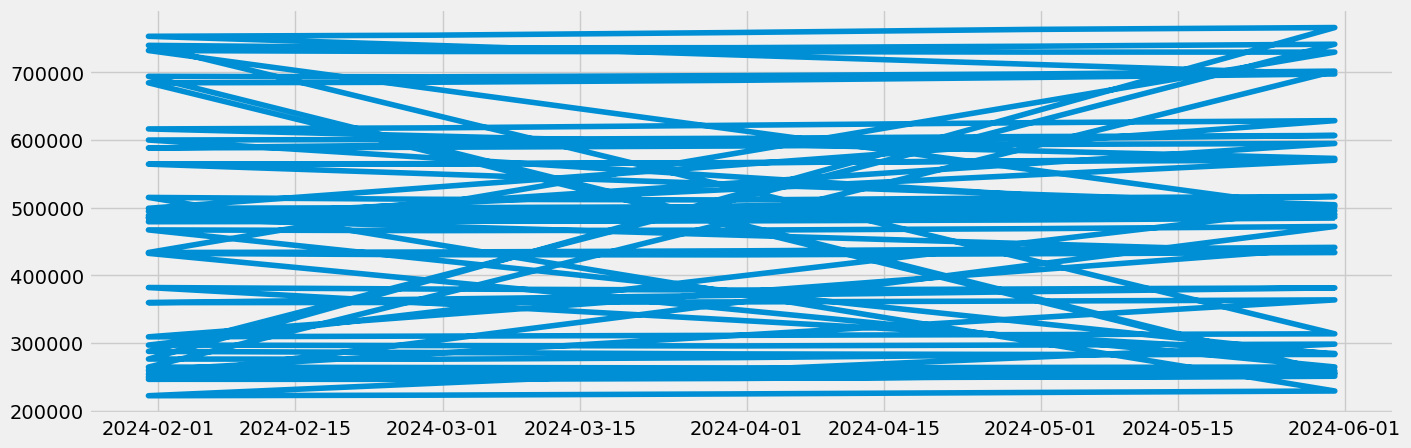

In [21]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_numerical_2_sub)

In [22]:
# Check for missing values (you shouldn't have any)

data_numerical_2_sub.isnull().sum() 

value    0
dtype: int64

In [23]:
# Check for duplicates

dups = data_numerical_2_sub.duplicated()
dups.sum()

# No dups!

0

In [24]:
data_numerical_2_sub.head()

,value
datetime,
2024-05-31,484599.091201
2024-04-30,481777.608669
2024-03-31,480423.651093
2024-02-29,480905.942125
2024-01-31,484672.057701


### 3. Time-series analysis: decomposition

In [25]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_numerical_2_sub, model='additive', period=15)

In [26]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

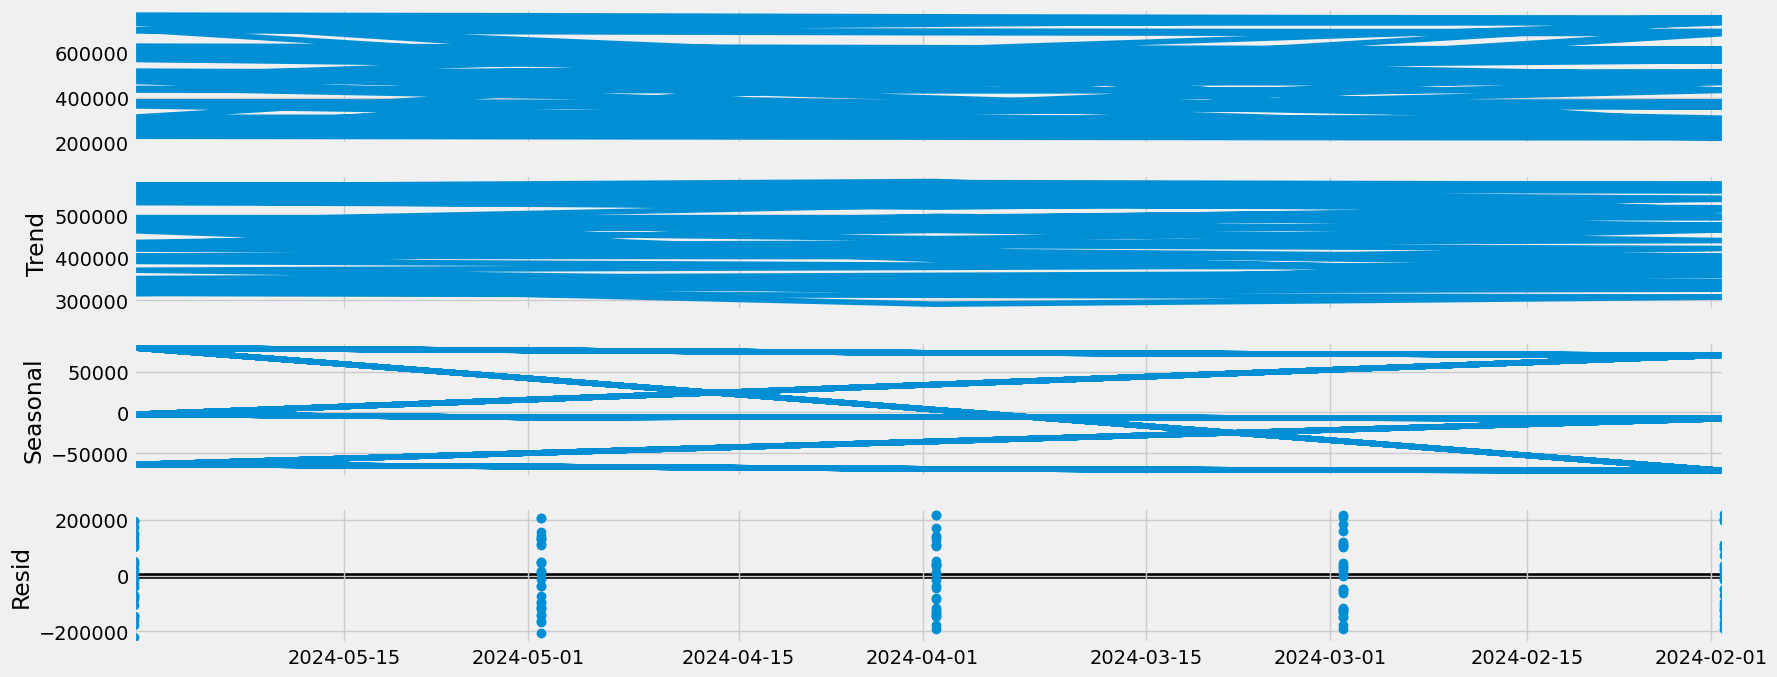

In [27]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [28]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_numerical_2_sub['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.756355
p-value                          0.064784
Number of Lags Used             10.000000
Number of Observations Used    149.000000
Critical Value (1%)             -3.475018
Critical Value (5%)             -2.881141
Critical Value (10%)            -2.577221
dtype: float64


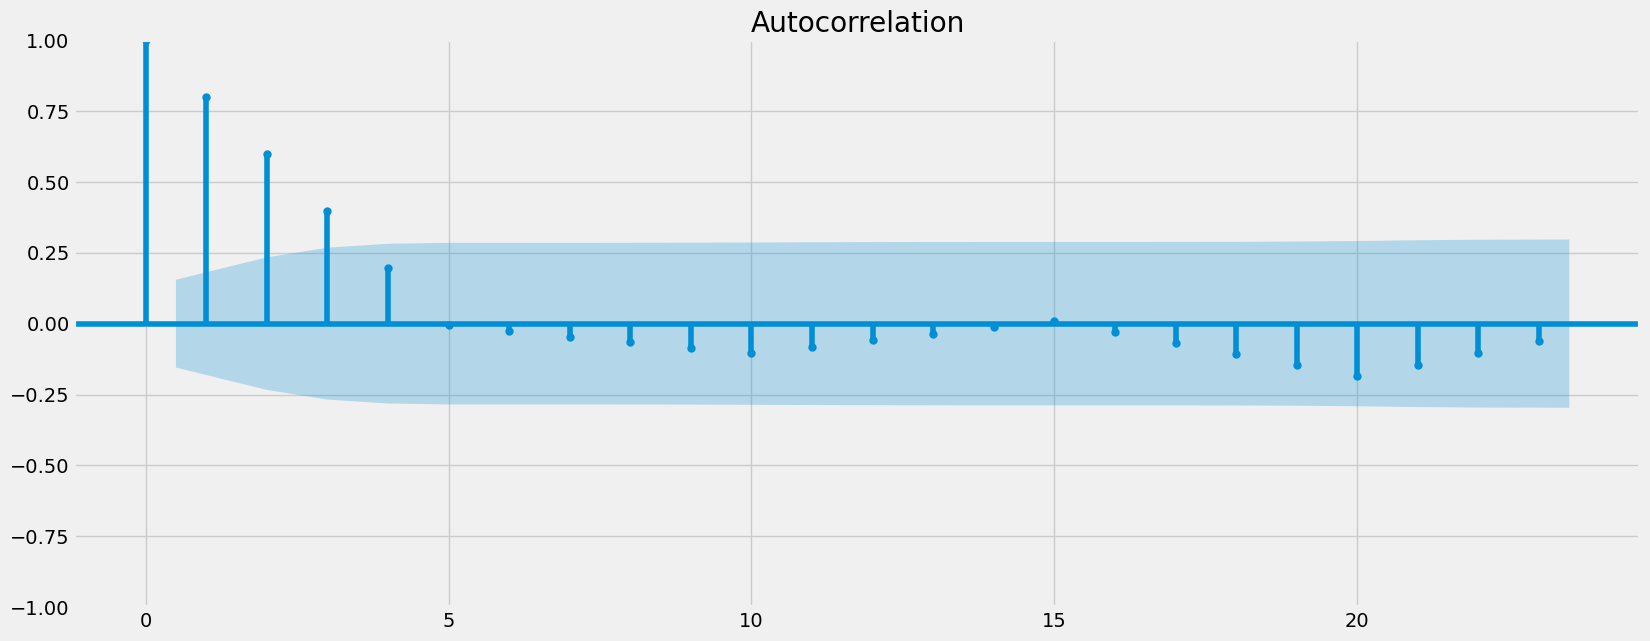

In [29]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_numerical_2_sub)
plt.show()

In [30]:
data_diff = data_numerical_2_sub - data_numerical_2_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [31]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [32]:
data_diff.head()

,value
datetime,
2024-04-30,-2821.482532
2024-03-31,-1353.957576
2024-02-29,482.291031
2024-01-31,3766.115576
2024-05-31,-51090.921331


In [33]:
data_diff.columns

Index(['value'], dtype='object')

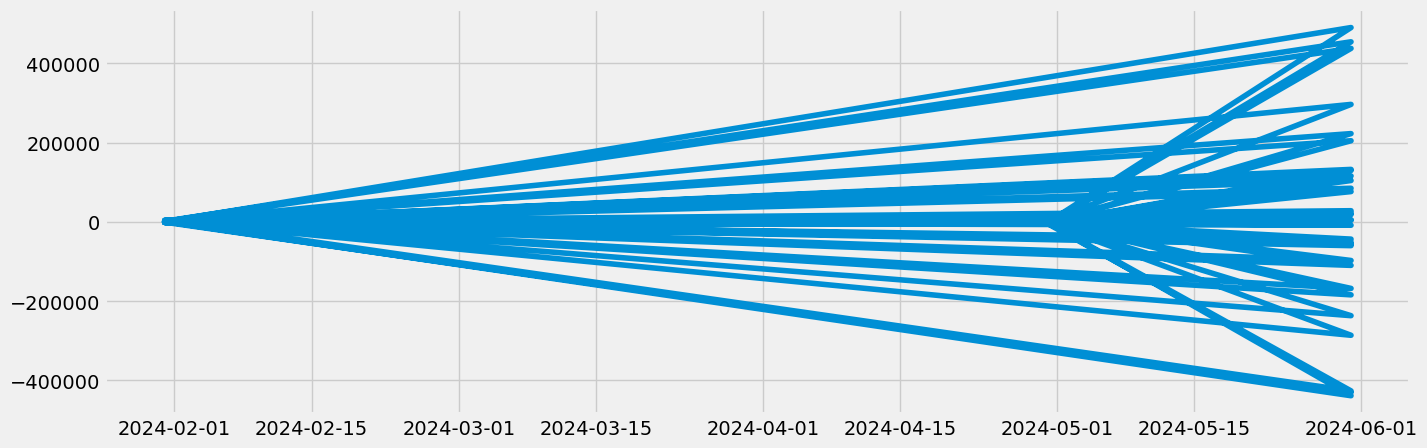

In [34]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [35]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.898486e+00
p-value                        1.300280e-09
Number of Lags Used            9.000000e+00
Number of Observations Used    1.490000e+02
Critical Value (1%)           -3.475018e+00
Critical Value (5%)           -2.881141e+00
Critical Value (10%)          -2.577221e+00
dtype: float64


In [ ]:
*** Interpretation of the Dickey-Fuller Stationarity test:
Our Test Statistic, -6.898486, is higher than the 10% and 5% critical value, which means that we can accept the null hypothesis 
(which is: the data is not stationary). Our p-value is 1.30, which means that the result is not significant.
We can consider the series stationary.

### 5. Check for autocorrelations

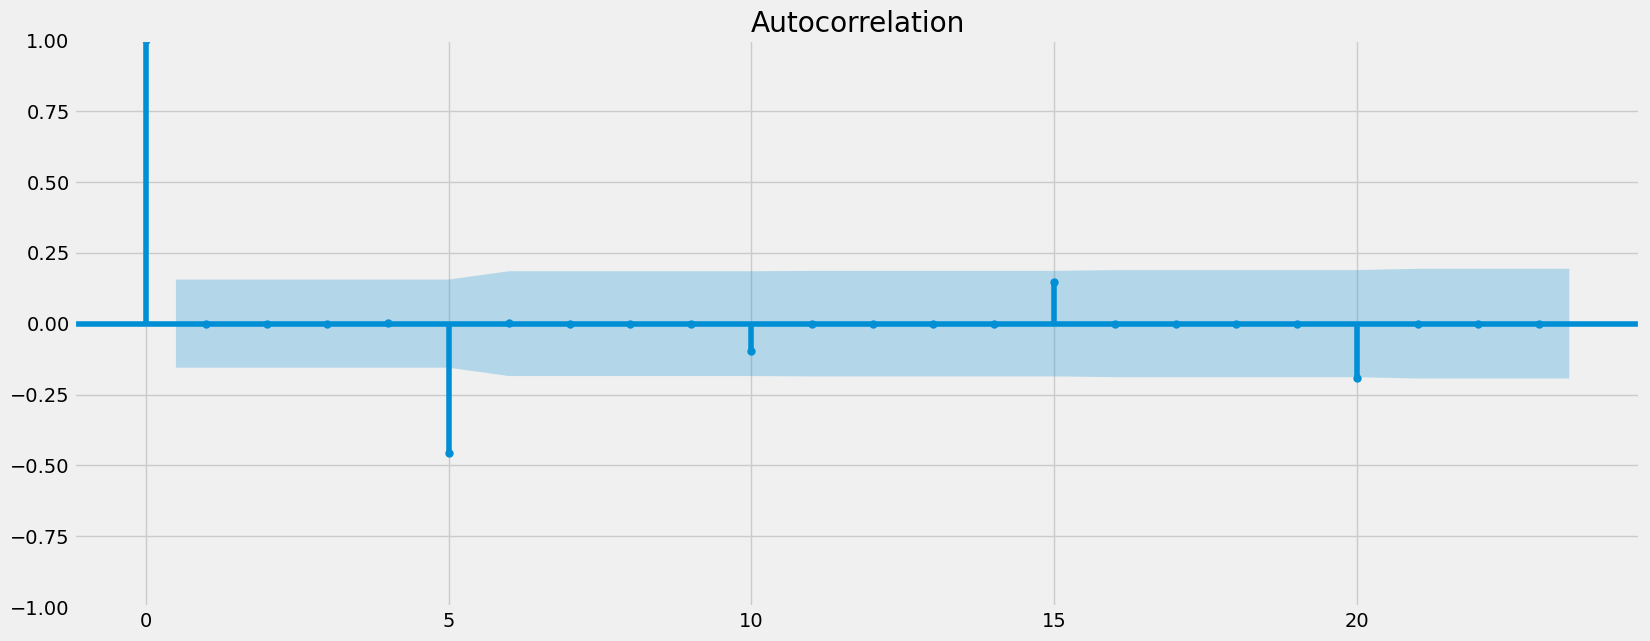

In [36]:
plot_acf(data_diff)
plt.show()

In [ ]:
***Interpretation:
We have 1 lags that are above the confidence interval, which means the data is not perfectly stationnary. 
It is, however, a small enough number of lags, and no differencing is necessary.